# Introduction

This is the jupyter notebook that contains all the configurations and running process to create and train the agents. The repository is cloned from [this](https://github.com/MammothStack/SingleSellerMarketGame) github repository:
The rules to monopoly and what this game is based on where taken from [this](http://www.math.yorku.ca/~zabrocki/math2042/Monopoly/prices.html) website




# Imports

## General

In [1]:
import pandas as pd
import numpy as np
import pprint
import time
import datetime
import sys
import os
import random
from random import randrange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

## tensorflow

In [2]:
import tensorflowjs as tfjs
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

Using TensorFlow backend.


## Repo imports

In [3]:
from src import GameController, Board, BoardError, Agent, OperationModel
from src.player import load_operation_model
from src.controller import get_game_controllers


In [4]:
from tests import test_game, test_operation_model

## Reloading imports before execution

In [5]:
%load_ext autoreload

In [6]:
%autoreload 1

In [7]:
%aimport src.controller

In [8]:
%aimport src.player

In [9]:
%aimport src.game

In [10]:
%aimport tests.test_game
%aimport tests.test_operation_model

In [11]:
%aimport

Modules to reload:
src.controller src.game src.player tests.test_game tests.test_operation_model

Modules to skip:



# Testing

In [12]:
import unittest
loader = unittest.TestLoader()
start_dir = "tests"
suite = loader.discover(start_dir)

runner = unittest.TextTestRunner()
runner.run(suite)

.............................................................................................................................

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


....
----------------------------------------------------------------------
Ran 129 tests in 8.518s

OK


<unittest.runner.TextTestResult run=129 errors=0 failures=0>

## Initialise Models

Here the Operation models and Agents are initialized. Here is where the tinkering starts. Things such as the learning rate, the rate at which the operation model makes random actions, etc, can be set here. The keras models are also initialized here.

In [59]:
def init_purchase_operation_model(
    name, level, epsilon_decay, rho_mode=1,
):
    k_model = init_purchase_model(
        name=name,
        loss="categorical_crossentropy",
        optimizer="adam",
    )
    om = OperationModel(
        model=k_model,
        input_dimensions=[393],
        output_dimensions=[2],
        operation="purchase",
        name=name,
        loss="categorical_crossentropy",
        optimizer="adam",
        true_threshold=0.5,
        single_label=True,
        rho=level,
        rho_mode=rho_mode,
        gamma=0.7,
        epsilon_decay=epsilon_decay,
    )

    return om


In [43]:
def init_purchase_model(input_shape=(393,), name=None, loss="categorical_crossentropy", optimizer="adam"):
    model = Sequential(name=name + "_purchase")
    model.add(Dense(input_shape=input_shape, units=256, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(units=128, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(units=64, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dropout(0.35))
    model.add(Dense(units=2, activation="softmax"))

    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
        
    return model

In [44]:
def init_up_down_grade_operation_model(
    name, level, epsilon_decay
):
    k_model = init_up_down_grade_model(
        name=name, loss="mse", optimizer="adam"
    )
    om = OperationModel(
        model=k_model,
        operation="up_down_grade",
        name=name,
        loss="mse",
        optimizer="adam",
        true_threshold=0.5,
        single_label=True,
        rho=level,
        rho_mode=1,
        gamma=0.7,
        epsilon_decay=epsilon_decay,
    )

    return om


In [45]:
def init_up_down_grade_model(input_shape=(393,), name=None, loss="mse", optimizer="adam"):
    model = Sequential(name=name + "_up_down_grade")
    model.add(Dense(input_shape=input_shape, units=256, activation="tanh"))
    model.add(Dropout(0.2))
    model.add(Dense(units=128, activation="tanh"))
    model.add(Dropout(0.1))
    model.add(Dense(units=64, activation="tanh"))
    model.add(Dropout(0.1))
    model.add(Dense(units=64, activation="tanh"))
    model.add(Dropout(0.1))
    model.add(Dense(units=57, activation="linear"))
    
    model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
        
    return model
                             

In [46]:
def init_trade_offer_operation_model(name, level=3):
    k_model = init_trade_offer_model(name=name)
    om = OperationModel(
        model=k_model,
        operation="trade_offer",
        name=name,
        loss="mse",
        optimizer="adam",
        true_threshold=0.5,
        single_label=False,
        rho=level,
        rho_mode=1,
        gamma=0.7,
    )

    return om


In [47]:
def init_trade_offer_model(input_shape=(616,), name=None):
    
    inp = Input(input_shape)
    
    x_0 = Dense(256, activation="relu")(inp)
    x_0 = Dropout(0.2)(x_0)
    x_0 = Dense(128, activation="relu")(x_0)
    x_0 = Dropout(0.2)(x_0)
    x_0 = Dense(64, activation="relu")(x_0)
    x_0 = Dropout(0.2)(x_0)
    #m_x0 = Model(inputs=inp_0, outputs=x_0)
    
    y_0 = Dense(256, activation="relu")(inp)
    #y_0 = Dropout(0.2)(y_0)
    y_0 = Dense(128, activation="relu")(y_0)
    #y_0 = Dropout(0.2)(y_0)
    y_0 = Dense(64, activation="relu")(y_0)
    #y_0 = Dropout(0.2)(y_0)
    #m_y0 = Model(inputs=inp_0, outputs=y_0)
    
    c_0 = concatenate([x_0, y_0])
    
    x_1 = Dense(64, activation="relu")(c_0)
    x_1 = Dropout(0.2)(x_1)
    x_1 = Dense(56, activation="relu")(x_1)
    x_1 = Dropout(0.2)(x_1)
    x_1 = Dense(56, activation="relu")(x_1)
    
    y_1 = Dense(64, activation="relu")(c_0)
    #y_1 = Dropout(0.2)(y_1)
    y_1 = Dense(16, activation="relu")(y_1)
    #y_1 = Dropout(0.2)(y_1)
    y_1 = Dense(4)(y_1)
    
    c_1 = concatenate([x_1, y_1])
    
    x_2 = Dense(56, activation="relu")(c_1)
    x_2 = Dropout(0.2)(x_2)
    x_2 = Dense(56, activation="relu")(x_2)
    
    y_2 = Dense(32, activation="relu")(c_1)
    #y_2 = Dropout(0.2)(y_2)
    y_2 = Dense(4, activation="relu")(y_2)
    y_2 = Dense(1, activation="linear")(y_2)
    
    model = Model(inp, [x_2, y_2], name=name + "_trade_offer")
    
    model.compile(loss=["categorical_crossentropy", "mse"], optimizer="adam", metrics=["accuracy"])
        
    return model

In [48]:
def init_trade_decision_operation_model(name, level=3):
    k_model = init_trade_decision_model(name=name, loss="mse", optimizer="adam")
    om = OperationModel(model=k_model, operation="trade_decision", name=name,loss="mse", 
                        optimizer="adam", true_threshold=0.5, single_label=True, 
                        rho=level, rho_mode=1, gamma=0.7)
    return om

In [49]:
def init_trade_decision_model(input_shape=(700,), name=None, loss="mse", optimizer="adam"):
    model = Sequential(name=name + "_trade_decision")
    model.add(Dense(input_shape=input_shape, units=256, activation="tanh"))
    model.add(Dropout(0.2))
    model.add(Dense(units=128, activation="tanh"))
    model.add(Dropout(0.1))
    model.add(Dense(units=64, activation="tanh"))
    model.add(Dropout(0.1))
    model.add(Dense(units=2, activation="tanh"))
    model.add(Dropout(0.1))
    model.add(Dense(units=1, activation="linear"))
    
    model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

        
    return model

## Get new pool

In [50]:
from random import sample

def get_new_pool(size, random=False, extend=None):

    colors = ['Amaranth','Amber','Amethyst','Apricot','Aquamarine',
          'Azure','Baby-blue','Beige','Black','Blue','Blue-green',
          'Blue-violet','Blush','Bronze','Brown','Burgundy',
          'Byzantium','Carmine','Cerise','Cerulean','Champagne',
          'Chartreuse-green','Chocolate','Cobalt-blue','Coffee',
          'Copper','Coral','Crimson','Cyan','Desert-sand',
          'Electric-blue','Emerald','Erin','Gold','Gray','Green',
          'Harlequin','Indigo','Ivory','Jade','Jungle-green',
          'Lavender','Lemon','Lilac','Lime','Magenta','Magenta-rose',
          'Maroon','Mauve','Navy-blue','Ocher','Olive','Orange',
          'Orange-red','Orchid','Peach','Pear','Periwinkle',
          'Persian-blue','Pink','Plum','Prussian-blue','Puce',
          'Purple','Raspberry','Red','Red-violet','Rose','Ruby',
          'Salmon','Sangria','Sapphire','Scarlet','Silver',
          'Slate-gray','Spring-bud','Spring-green','Tan','Taupe',
          'Teal','Turquoise','Ultramarine','Violet','Viridian',
          'White','Yellow']
    
    if extend is None:
        if size > len(colors):
            raise ValueError
        
        sam = sample(colors, size)
        pool = []
    else:
        if size + len(extend) > len(colors):
            raise ValueError
        
        extend_names = [p.name for p in extend]
        r_colors = [color for color in colors if color not in extend_names]
        sam = sample(r_colors, size)

        pool = extend
    
    for color in sam:
        p_m = init_purchase_operation_model(color, np.random.randint(1,6), epsilon_decay=0.995, rho_mode=1)
        u_m = init_up_down_grade_operation_model(color, np.random.randint(1,6), epsilon_decay=0.997)
        t_o_m = init_trade_offer_operation_model(color, np.random.randint(1,6))
        t_d_m = init_trade_decision_operation_model(color, np.random.randint(1,6))
        
        pool.append(Agent(color, p_m, u_m, t_o_m, t_d_m))
    
    return pool
    

In [51]:
def add_new_operation_model(player, purchase=True, up_down_grade=True, trade_offer=True, trade_decision=True):
    color = player.name
    if purchase:
        p_m = init_purchase_operation_model(color)
        player.models["purchase"] = p_m
        
    if up_down_grade:
        u_m = init_up_down_grade_operation_model(color)
        player.models["up_down_grade"] = u_m
        
    if trade_offer:
        t_o_m = init_trade_offer_operation_model(color)
        player.models["trade_offer"] = t_o_m
        
    if trade_decision:
        t_d_m = init_trade_decision_operation_model(color)
        player.models["trade_decision"] =  t_d_m
        
    #return player

## Setup Launch

In [102]:
def run_game(
    controller, 
    iterations, 
    purchase=True, 
    up=True, 
    trade=True, 
    game_results=True,
    verbose=False):
    dfs = []
    for i in range(iterations):
        if verbose:
            clear_output(wait=True)
            
        results = controller.start_game(purchase=purchase,up_down_grade=up, trade=trade)
        dfs.append(pd.DataFrame.from_dict(results))
        controller.reset_game()
        
        if verbose:
            print("Current progress:", np.round(((i+1)/iterations) * 100, 2), "%")
        
    if game_results:
        summary = pd.concat(dfs,axis=1)
        summary = summary.T
        summary.reset_index(drop=True, inplace=True)
        return summary
        

In [101]:
def run_games(bcs, iterations=3, up=True, trade=True, results=True, graph=True):
    summary_dfs = []
    #summary_logs = []
    plt.close("all")
    
    for bc in bcs:
        print(list(bc.players.keys()))
        #print(bc.dynamic_reward_risk_level)
        summary = run_game(bc, iterations, up=up, trade=trade, game_results=results)
        
        if results and graph:
            graph_owned(summary, str(list(bc.players.keys())))
            if up:
                graph_level(summary, str(list(bc.players.keys())))
            
        summary_dfs.append(summary)
        #summary_logs.append(logs)
        
    return summary_dfs

In [68]:
def graph_level(summary, name, save=False):
    x = summary.index
    y = summary["prop_average_level"]
    
    labels, levels = pd.factorize(summary["name"])
    colors = labels * (100 / (len(summary["name"].unique())))

    plt.figure(figsize=(20,10))
    plt.scatter(x, y, alpha=0.4, c=colors, cmap='plasma')
    plt.xlim(0, len(summary))
    plt.ylim(0, 6)
    plt.title = name + " level"

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")

    if save:
        plt.savefig(str(list(bc.players.keys())) + ".png", bbox_inches='tight')

In [98]:
def graph_owned(summary, name, save=False):
    x = summary.index.values
    y = summary["prop_owned"].values
    
    labels, levels = pd.factorize(summary["name"])
    colors = labels * (100 / (len(summary["name"].unique())))
    size = summary["prop_average_level"].values * 100

    plt.figure(figsize=(20,10))
    plt.title = name + " owned"
    plt.scatter(x, y, c=colors, s=size.tolist(), alpha=0.4, cmap='plasma')
    plt.xlim(0, len(summary))
    plt.ylim(0, 28)
    
    
    #z = np.polyfit(np.asarray(x), np.asarray(y), 1)
    #p = np.poly1d(z)
    #plt.plot(x,p(x),"r--")

    if save:
        plt.savefig(str(list(bc.players.keys())) + ".png", bbox_inches='tight')

## Launch

In [77]:
pool = [
    Agent("blue", init_purchase_operation_model(name="blue", level=3, epsilon_decay=0.995)),
    Agent("red", init_purchase_operation_model(name="red", level=3, epsilon_decay=0.995))
]

In [78]:
pool

[Agent, 'blue', [OperationModel(name: 'blue', operation: 'purchase', trained episodes: 0, epsilon: 1.0, running reward: 0)],
 Agent, 'red', [OperationModel(name: 'red', operation: 'purchase', trained episodes: 0, epsilon: 1.0, running reward: 0)]]

In [115]:
contr = get_game_controllers(
    pool=pool, 
    n_players=1, 
    config={
        "reward_scalars":{
            "cash": 0.005, 
            "value": 0.01, 
            "rent": 0.005, 
            "monopoly": 1.0
        }
    }
)

['red']
['blue']


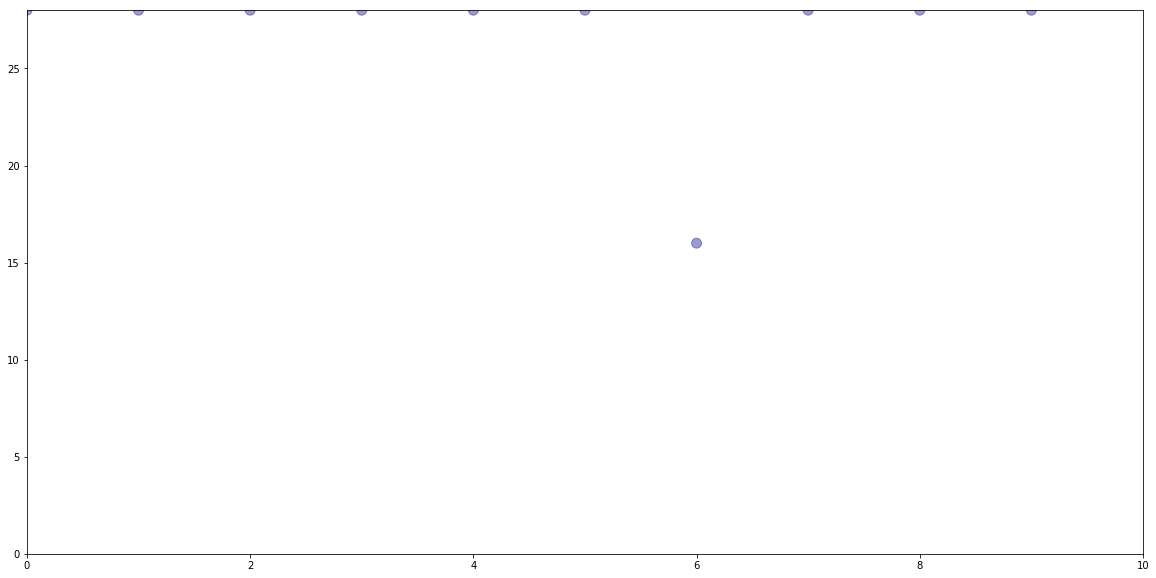

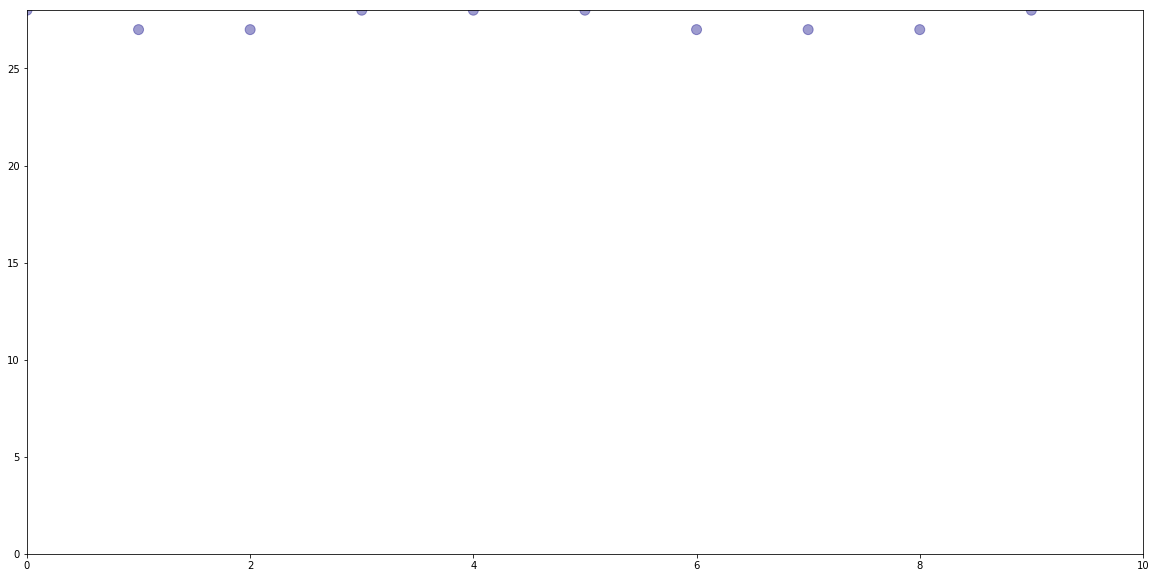

In [116]:
summary_dfs = run_games(contr, iterations=10, up=False, trade=False, results=True)

In [ ]:
for df in summary_dfs:
    print(df["name"].unique(), df["prop_average_level"].mean())

In [ ]:
def get_ranked_names(summaries, category, threshold):
    l = [(s["name"].unique()[0], s[category].mean()) for s in summaries]
    s_names = sorted(l, reverse=True, key=lambda x: x[1])
    
    reduced = [name[0] for name in s_names if name[1] > threshold]
    
    return reduced

## Testing

In [29]:
b = Board("red","blue")

In [33]:
a1 = b.get_general_state()

In [34]:
a2 = b.get_player_state("red")

In [36]:
np.concatenate([a1, a2]).shape

(393,)

In [82]:
agent = pool[0]

In [87]:
agent.models["purchase"]